# An intuition behind a neural network
Throughout this notebook, we will build an intuition for how neural networks can learn any representation or mapping. We'll start by implementing a linear classifier with a logistic unit for a synthetic, linearly separable dataset to understand the role of linear transformations. Next, we'll generate a more complex dataset and explore how a neural network can create a perfect decision boundary to separate the classes. We'll see how the neural network can effectively learn this boundary by leveraging our previous understanding of linear transformations and introducing a non-linearity on top of it.




## Importing necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Dataset Generation

We will first generate two Gaussians distributed classes labeled 0 and 1 that can be perfectly linearly separable. Then we will explore how to learn a perfect linear boundary that can split both distributions and can classify accuretly to which class a point belongs to.

In [2]:
torch.manual_seed(7)
x1 = torch.randn(100,2)
x2 = (x1 - 4.5)
x = torch.cat((x1,x2), dim=0)
y = torch.cat((torch.ones(100,1),torch.zeros(100,1)),dim=0)

## Learning the linear classifier

To learn the linear boundary, we need to find the parameters that define a line separating the two classes. In general, for an n-dimensional space, we find a hyperplane whose points satisfy the equation $w^T x + b = 0$. A hyperplane is an affine subspace with one dimension less than the space it resides in. In our case, we are working in 2D, so the hyperplane is just a line that separates the points in one-dimensional space.

The points that lie on one side of the hyperplane will have $w^T x + b > 0$, while the others will have $w^T x + b < 0$.

How can we find this hyperplane ?



There are several techniques in machine learning that aim to find this hyperplane and learn its parameters through the data, for this example we will  use a logistic unit, which calculates the probability of a data point belonging to a particular classn: $ P(Y = 1 \mid X) = \frac{1}{1 + e^{-(w^T X + b)}}$

There is an interesting proof from where this functional form comes from (Tom Mitchell). In short, it comes from the goal to try to estimate $P(Y\mid X)$  that when given given our features X, what is the probability that it belongs to a class. To estimate this, we use the Bayes theoreme to get to this equation where $ P(Y \mid X) = \frac{P(X \mid Y) P(Y)}{P(X)}$ , and estimate the quantities from the data. Eventually, we have to make an assumption about the distribution of $P(X \mid Y)$ and when we assume that the features X are independent and Gaussian distributed then add then $P(Y \mid X)$ converges to this form: $
P(Y = 1 \mid X) = \frac{1}{1 + \exp\left(-(w^T X + b)\right)}
$ and
$
P(Y = 0 \mid X) = \frac{\exp\left(-(w^T X + b)\right)}{1 + \exp\left(-w^T X + b)\right)}
$ where $w_i = \frac{\mu_{i0} - \mu_{i1}}{\sigma^2_i}$ and $b = \ln\left(\frac{1-\pi}{\pi}\right) + \sum_i \frac{\mu_{i1}^2 - \mu_{i0}^2}{2\sigma^2_i}$ where $( u_0 )$  is the mean for a feature i for the class 0 and $( u_0 )$ for the class 1 and $\sigma_i$ is the standard deviation of the feature. We can directly calculate those parameters from the data and thus estimate $P(Y\mid X)$, or we can say that our goal is only to being able to find the parameters that maximize the probability of the observed values Y $arg\max_{W} P(Y_1, Y_2, \dots, Y_n \mid X_1, X_2, \dots, X_n; W)$, which more formally is known as maximum likelihood estimation. As the observations are independent it simplifies to  $$arg\max_{W} P(Y_1, Y_2, \dots, Y_n \mid X_1, X_2, \dots, X_n; W) = arg\max_{W}\prod_{i=1}^{n} P(Y_i \mid X_i; W) $$
Introducing the log for more convienience and to avoid the multiplication of multiple small probabilities: $ \arg\max_{W} \sum_{i=1}^{n} \log P(Y_i \mid X_i; W)$
For classes labeled 1 and 0, $\log P(Y_i \mid X_i; W)$ can be written as: $\log P(Y_i \mid X_i; W) = Y_i \log(P(Y_i = 1 \mid X_i)) + (1-Y_i) \log(1-P(Y_i = 1 \mid X_i))$, where $
P(Y = 1 \mid X) = \frac{1}{1 + \exp\left(-(w^T X + b)\right)}
$. In general our goal would be to find W that maximizes this conditional likelihood $L(W)= \sum_{i=1}^{n} Y_i \log(P(Y_i = 1 \mid X_i)) + (1-Y_i) \log(1-P(Y_i = 1 \mid X_i))$. There is no closed form to get to the best W that maximizes the likelihood, but what we typically do is negate this formula and use gradient descent to get to the local minimum.
This algorithm is called logistic regression and what at then it finds it the best hyperplane $w^T x + b = 0$ that best seperates the two classes through maximizing the conditional likelihood.  It won't give the same results as a Gaussian Naive Bayes despite having the same functionnal form since it just cares about maximizing the likelihood by finding the best hyperplane, while Guassian naive bayes would estimate directly those parameters through its assumpmtions of the gaussian distributtion and conditonnal indepence.






In [3]:
model = nn.Sequential(
    nn.Linear(2,1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [4]:
for step in range(1001):
  pred = model(x)
  loss = F.binary_cross_entropy_with_logits(pred,y)
  if step % 100 == 0:
    print(f'step:{step}, loss:{loss:.4f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

step:0, loss:0.3665
step:100, loss:0.1391
step:200, loss:0.0858
step:300, loss:0.0630
step:400, loss:0.0504
step:500, loss:0.0423
step:600, loss:0.0367
step:700, loss:0.0325
step:800, loss:0.0293
step:900, loss:0.0268
step:1000, loss:0.0247


In [5]:
def plot_scatter(x, w1, b1, w2=None, b2=None):
    boundary_x = torch.tensor([-10, 10])
    boundary1_y = - (boundary_x * w1[0] + b1) / w1[1]

    plt.figure(figsize=(8, 6))
    plt.grid(True)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(x[:100, 0], x[:100, 1], s=20, c="blue")
    plt.scatter(x[100:, 0], x[100:, 1], s=20, c="red")
    plt.plot(boundary_x, boundary1_y, color="green")
    if w2 is not None and b2 is not None:
        boundary2_y = - (boundary_x * w2[0] + b2) / w2[1]
        plt.plot(boundary_x, boundary2_y, color="green")

    plt.show()

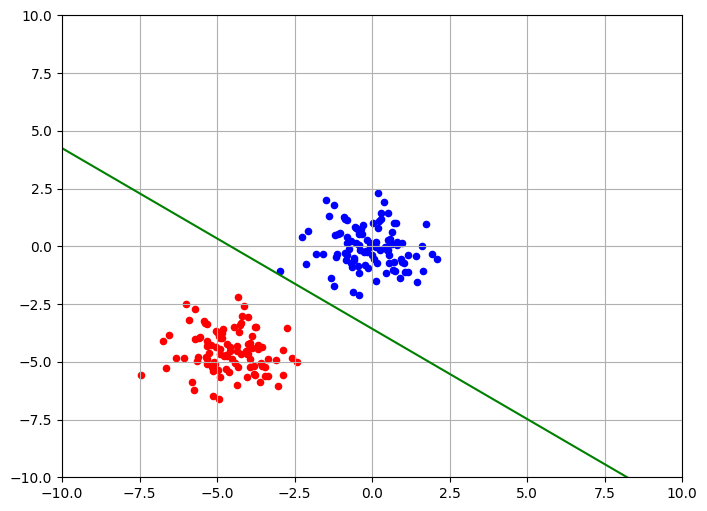

In [6]:
weights = model[0].weight[0].detach().numpy()
bias = model[0].bias.detach().numpy()
plot_scatter(x,weights,bias)

We can see that we effectively learned the hyperplane that seperates our data through a logistic unit and the hyperplane comes from the linear transformation applied to the input. What if the classes are not linearly seperable, what would be the result of the logistic unit.

## Generation of a non linearly seperable dataset and fitting the same model

In [7]:
torch.manual_seed(7)
x1 = torch.randn(100,2)
x2 = x1 - 4.5
x3 = x2 + 12
x3[:,1] = x3[:,1] - 5

In [8]:
x= torch.cat((x1,x2,x3), dim=0)
y= torch.cat((torch.zeros(100,1), torch.ones(200,1)), dim=0)

In [9]:
model = nn.Sequential(
    nn.Linear(2,1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for step in range(1000):
  pred = model(x)
  loss = F.binary_cross_entropy_with_logits(pred,y)
  if step % 100 == 0:
    print(f'step:{step}, loss:{loss:.4f}')
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

step:0, loss:1.3227
step:100, loss:0.4148
step:200, loss:0.4010
step:300, loss:0.3972
step:400, loss:0.3959
step:500, loss:0.3955
step:600, loss:0.3953
step:700, loss:0.3953
step:800, loss:0.3953
step:900, loss:0.3952


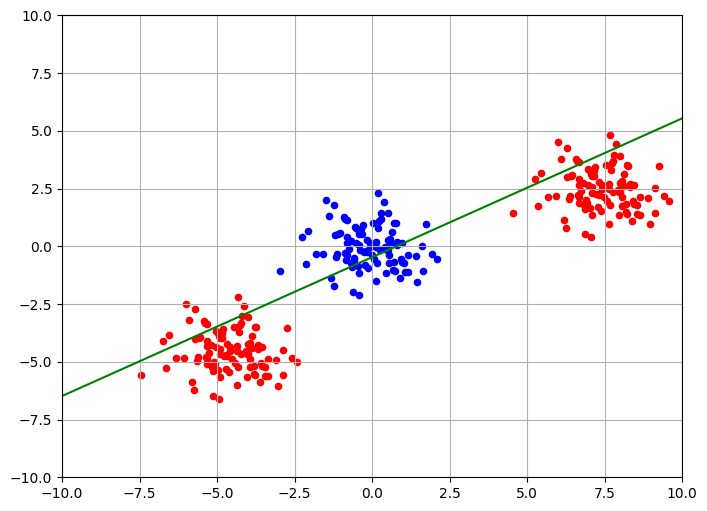

In [10]:
weights = model[0].weight[0].detach().numpy()
bias = model[0].bias.detach().numpy()
plot_scatter(x, weights, bias)

As we can see, its is impossible to find a hyperplane that seperates the classes, which now will lead us to how a neural netwok can learn a perfect boundary to split the classes. A neural network is characterized by linear transformation with a non linear activation function applied to them $f(x) = w^Tσ(Ux + c) + b$. We can think of it as $W_1$ the weight matrix that consists of several row vectors, where each row vector multiplied by the input x is just a hyperplane as we have seen  before and multiplyting it by $w_2^T$ is just a weighted some of the hyperplanes and the function can be rewritten this way with using the ReLU non-linear function: $f(x) = \sum_{i}^{m} w_imax(0,u_i^Tx + c_i) + b$. So essentially, we are using several hyperplanes to draw our boundary and we are introducing the non-linear function like the ReLU that sets either a hyperplane to 0 and does not use it for some region of the input and adds those boundaries together to create a complex non linear one.

Following our previous example, we will visualize the boundary produced by a neural network to demonstrate how the boundary is represented by a combination of the hyperplanes in the weight matrix and shifted with the bias b.

In [11]:
torch.manual_seed(7)
model = nn.Sequential(
    nn.Linear(2,2),
    nn.ReLU(),
    nn.Linear(2,1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for step in range(5001):
    pred = model(x)
    loss = F.binary_cross_entropy_with_logits(pred, y)

    if step % 1000 == 0:
        print(f'step:{step}, loss:{loss:.4f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # For the sake of the example we make it a simple sum of the hyperplanes as the neural net can learn more complex sums.
    with torch.no_grad():
        model[2].weight.fill_(1.0)



step:0, loss:0.7781
step:1000, loss:0.0211
step:2000, loss:0.0116
step:3000, loss:0.0083
step:4000, loss:0.0065
step:5000, loss:0.0054


In [12]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[-1.3781, -1.8741],
        [ 1.8580,  0.7835]], requires_grad=True)
Parameter containing:
tensor([-1.8928, -1.3354], requires_grad=True)
Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([-5.4359], requires_grad=True)


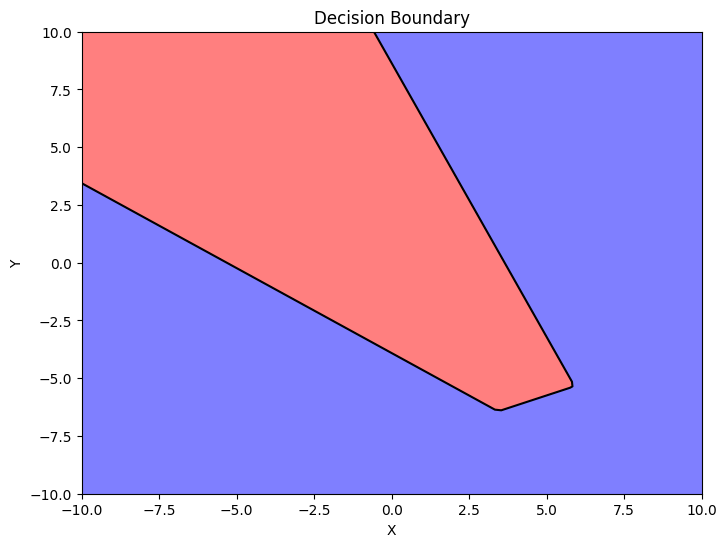

In [13]:
X = torch.linspace(-10, 10, 100)
Y = torch.linspace(-10, 10, 100)

X, Y = torch.meshgrid(X, Y, indexing='ij')
input = torch.stack((X.flatten(), Y.flatten()), dim=1)
output = model(input).detach().reshape(100, 100)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, output, levels=[-float('inf'), 0, float('inf')], colors=['red', 'blue'], alpha=0.5)
plt.contour(X, Y, output, levels=[0], colors='k', linestyles='-')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Decision Boundary')
plt.show()

From the decision boundary, we can see that it is composed of three linear units but essentially they are just two as we only used two hyperplanes and the third one is a result of both hyperplanes switched on with ReLU and summed over.
We can alos plot directly the hyperplanes from the weight matrix and since we are just doing a simple sum of both it will look similar.

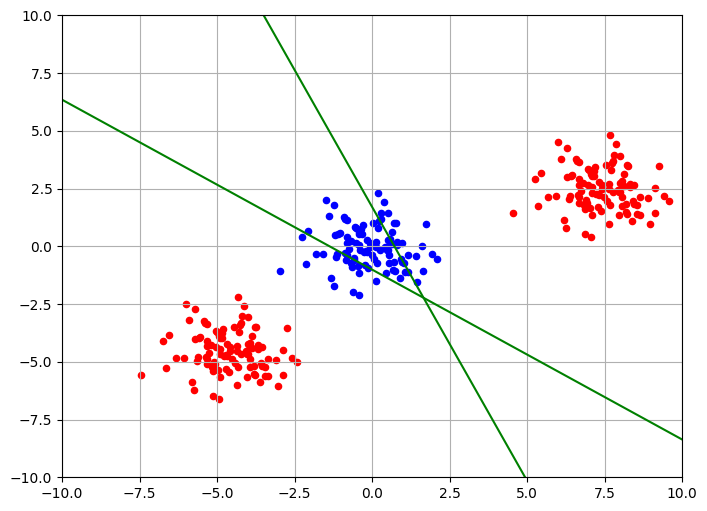

In [14]:
b2 = model[2].bias.item()
w1_1 = model[0].weight[0].detach().numpy()
b1_1 = model[0].bias[0].item()
w1_2 = model[0].weight[1].detach().numpy()
b1_2 = model[0].bias[1].item()
w2_1 = model[2].weight[0,0].detach().numpy()
w2_2 = model[2].weight[0,1].detach().numpy()
plot_scatter(x, w1_1, b1_1, w1_2, b1_2)

We’ve built a solid understanding that a neural network can, in theory, approximate any function by using hyperplanes as building blocks and combining them to create the final decision boundary. This means that, theoretically, we can approximate any function with just two layers. However, this approach isn’t efficient because it requires a large number of parameters.

By introducing more layers, the network can reuse the simple linear functions learned in the initial layer and combine them in the second layer to create more complex functions. The third layer would again combine these nonlinear functions into even more complex ones, and so on. This allows us to approximate the same function with fewer parameters, making the network more efficient and effective in capturing complex patterns.

## Choice of the non-linearity

For this example we have used the ReLU non-linearity, but in theory any arbitrary non-linear function can be used so the choice of the the function is only for practicle reasons where gradients are easy to calculate and that it does not cause issues during back propagation. For a long time sigmoid function that we have seen in the logistic unit was the go to as it is a good analogy to the human brain and the actitivation of the neurons as the firing rate however it suffers from multiple issues and one of them is vanishing gradient during backpropagation due to the nature of the function.

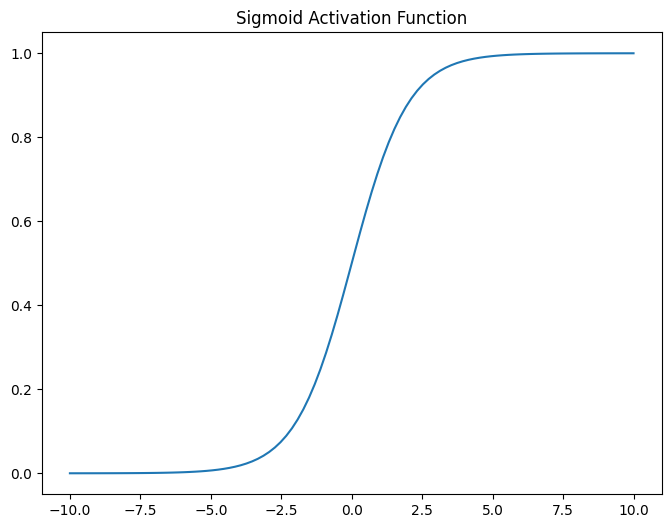

In [15]:
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))

plt.figure(figsize=(8,6 ))
plt.plot(x, y)
plt.title('Sigmoid Activation Function')
plt.show()

The output of a neuron is calculated as $a = \sigma(Wx + b)$, where $\sigma$ is the sigmoid function. During backpropagation, we calculate the gradient with respect to the parameters using the chain rule, giving us $\frac{da}{dw} = \frac{da}{dz} \cdot \frac{dz}{dw}$, where $\frac{dz}{dw} = x$. The derivative $\frac{da}{dz} = \sigma(z) \cdot (1 - \sigma(z))$ depends on the activation of the neuron. When the activation is very high or very low, we can notice just from the graph that the gradient becomes close to zero, leading to the vanishing gradient problem. This can cause the neuron to stop learning, as it fails to backpropagate gradients back through the network, which for larger networks with many neurons in this state will cause the entire network to get stuck.

This makes sigmoid a terrible function to use for your network. The ReLU activation, in contrast, is computationally simple and does not suffer from this issue in the positive region, as the gradients are just one. However, for negative activations, the gradient is still 0, and the neuron won't backpropagate any information. This isn't a significant problem because, when you think about it, a neuron with negative activation is not concerned by that particular input and should not be updated. Nevertheless, it shouldn't be neglected that there are newly proposed activation functions similar to ReLU but without a zero gradient in the negative part, in an attempt to combat vanishing gradients and potentially lead to faster training. But generally, ReLU is a very good activation function that scales well with deep networks and speeds up the training process.
